# Fashion Mnist
This project was made as a university assignment.

We have 32x32 images in grayscale, they were made from Fashion Mnist dataset. The task is to classify images into specified labels. Training data is in train.csv. We will experiment with feedforward neural networks (FNNs) and convolutional neural networks (CNNs).

There are several labels:
* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandal
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle boot

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load data and data preprocessing

In [2]:
#Reshape the data
def reshape_data(data):
    tmp = data.reshape(-1, 1, 32, 32)
    return tmp

#Scale dataset
def scale_one(scaler, train, target_data):
    train_scaled = scaler.fit_transform(train)
    res = scaler.transform(target_data)
    return reshape_data(res)

#Scale train, val and test sets
def scale_data(scaler, train, val, test):
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)

    return reshape_data(train_scaled), reshape_data(val_scaled), reshape_data(test_scaled)

#Create a tensor dataset
def create_dataset(data, data_res):
    tmp = torch.utils.data.TensorDataset(torch.tensor(data).to("cuda"), torch.tensor(data_res.values).to("cuda"))
    return tmp

#Create a dataloader for models
def create_loader(data, batch_s, shuffle):
    tmp = torch.utils.data.DataLoader(data, batch_size=batch_s, shuffle=shuffle)
    return tmp

Training dataset has 52500 rows and 1025 features.

Features **pixel1**-**1024** represent pixels in the imaxe (from left to right, row by row). Pixel values range from 0 to 255, the higher the number, the darker the corresponding pixel.

There are no missing values in the dataset.

Training dataset will be divided into training (60%), validation (20%) and testing (20%) set.

In [3]:
df = pd.read_csv('train.csv')
Xdata = df.copy()
_ = Xdata.drop('label', axis=1, inplace=True)
Ydata = df['label']

rd_seed = 10 #Fixed seed
train, test, train_res, test_res = train_test_split(Xdata, Ydata, test_size=0.4, random_state=rd_seed)
val, test, val_res, test_res = train_test_split(test, test_res, test_size=0.5, random_state=rd_seed)

In [4]:
df.head()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,3
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5


In [5]:
print("Shape: " + str(df.shape))
print()
print(df.info())
print()
print("Number of null values: " + str(df.isnull().sum().sum()))

Shape: (52500, 1025)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB
None

Number of null values: 0


The average pixel value is 44.74 in the training set.

In [6]:
print(round(train.mean().mean(), 2))

44.74


We will display few images from the training set.

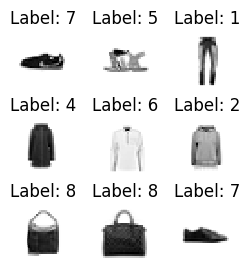

In [7]:
n_row, n_col = 3, 3
fig, axes = plt.subplots(n_row, n_col, figsize=(1*n_col, 1*n_row))
axes = axes.ravel()

for i in range(n_row*n_col):
    img = train.iloc[i, :].values.reshape(32, 32)
    axes[i].imshow(img, cmap='gray_r', interpolation='nearest')
    axes[i].set_title('Label: ' + str(train_res.iloc[i]))
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

We will apply standardization and MinMax normalization. The data will be then transformed into a suitable form for our neural networks. 

In [8]:
scaler = StandardScaler()
train_stand, val_stand, test_stand = scale_data(scaler, train, val, test)

scaler = MinMaxScaler()
train_mm, val_mm, test_mm = scale_data(scaler, train, val, test)

train_rs = reshape_data(train.to_numpy().copy())
val_rs = reshape_data(val.to_numpy().copy())
test_rs = reshape_data(test.to_numpy().copy())

In [9]:
train_data = create_dataset(train_rs, train_res)
train_data_stand = create_dataset(train_stand, train_res)
train_data_mm = create_dataset(train_mm, train_res)

val_data = create_dataset(val_rs, val_res)
val_data_stand = create_dataset(val_stand, val_res)
val_data_mm = create_dataset(val_mm, val_res)

test_data = create_dataset(test_rs, test_res)
test_data_stand = create_dataset(test_stand, test_res)
test_data_mm = create_dataset(test_mm, test_res)

In [10]:
training_loader = create_loader(train_data, 32, True)
validation_loader = create_loader(val_data, 128, False)
test_loader = create_loader(test_data, 128, False)

training_loader_stand = create_loader(train_data_stand, 32, True)
validation_loader_stand = create_loader(val_data_stand, 128, False)
test_loader_stand = create_loader(test_data_stand, 128, False)

training_loader_mm = create_loader(train_data_mm, 32, True)
validation_loader_mm = create_loader(val_data_mm, 128, False)
test_loader_mm = create_loader(test_data_mm, 128, False)

# Helper functions for our models

In [11]:
#Get model accuracy on given dataset
def get_acc(model, dataset, loader):
    predictions = np.zeros(len(dataset))
    y_data = np.zeros(len(dataset))
    ii = 0

    for vdata in loader:
        vinputs, vlabels = vdata
        with torch.no_grad():
            voutputs = model(vinputs.to(torch.float32))
        predictions[ii:(ii + vinputs.shape[0])] = voutputs.cpu().argmax(1).numpy()
        y_data[ii:(ii + vinputs.shape[0])] = vlabels.cpu().numpy()
        ii += vinputs.shape[0]
    print(f"Test accuracy: {accuracy_score(y_data, predictions)}")

In [12]:
#Train one epoch
def train_one_epoch(model, loss_fn, optimizer, train_l):
    running_cum_loss = 0.

    for data in train_l:
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(torch.float32))
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]
            
    return running_cum_loss / len(train_data)

In [13]:
#Training loop
def net_train(model_t, train_l, val_l, optimizer):
    EPOCHS = 25
    tmp_acc = 0

    loss_fn = torch.nn.CrossEntropyLoss()

    tmp_acc = 0

    for epoch in range(EPOCHS):
        
        model_t.train(True)
        avg_loss = train_one_epoch(model_t, loss_fn, optimizer, train_l)
        model_t.train(False)

        running_cum_vloss = 0.0
        vcorrect = 0
        for vdata in val_l:
            vinputs, vlabels = vdata
            with torch.no_grad():
                voutputs = model_t(vinputs.to(torch.float32))
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()

        avg_vloss = running_cum_vloss / len(val_data)
        vacc = vcorrect / len(val_data)

        tmp_acc = vacc
    
    return tmp_acc.cpu().numpy()

In [14]:
#Training loop with early-stopping regularization (based on validation accuracy)
def net_train_early_stopping(model_t, train_l, val_l, model_path, optimizer, save=False):
    MAX_EPOCHS = 30
    K_EPOCHS = 5

    epochs = []
    train_loss = []
    best_val_acc = 0
    validation_loss = []
    epochs_from_best = 0

    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(MAX_EPOCHS):
        model_t.train(True)
        avg_loss = train_one_epoch(model_t, loss_fn, optimizer, train_l)   
        model_t.train(False)

        running_cum_vloss = 0.0
        vcorrect = 0
        for vdata in val_l:
            vinputs, vlabels = vdata
            with torch.no_grad():
                voutputs = model_t(vinputs.to(torch.float32))
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()

        avg_vloss = running_cum_vloss / len(val_data)
        vacc = vcorrect / len(val_data)

        epochs.append(epoch)
        validation_loss.append(avg_vloss)
        train_loss.append(avg_loss)

        if vacc > best_val_acc:
            best_val_acc = vacc
            if save:
                torch.save(model_t.state_dict(), model_path)
            epochs_from_best = 0
        else:
            epochs_from_best += 1

        if epochs_from_best > K_EPOCHS:
            break

    return best_val_acc.cpu().numpy()

# Models

We will try two types of neural networks: feedforward and convolutional.

We will experiment with different layer depths/sizes, optimization and regularization methods. We will use standardization/normalization.

Regularization: early-stopping (stopping training after k-epochs of no improvement), dropout(2d) (resetting random inputs/channels to layer)

Optimization methods: Adam and SGD + different learning rates

Several models were tried, but only the more important ones were left. The activation functions RELU and softmax (in the loss function) were used.

Disclaimer: The training of neural networks does not always turn out the same (with the same model), the observations I made were made from the average of several attempts.

# FNN

Feedforward neural networks are generally not bad at image classification. Each neuron is connected to each neuron in the following layer, each pixel is taken as a separate feature, which can lead to high dimensionality of the inputs. This type does not capture much spatial information (like surrounding pixels).

In [15]:
# Generic model for layer number tuning, static layer size
# class forward_net_gen(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, layers_num):
#         super().__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.layers_num = layers_num

#         self.layers = nn.ModuleList()

#         self.layers.append(nn.Linear(input_size, hidden_size).to("cuda"))
#         for i in range(self.layers_num-2):
#             self.layers.append(nn.Linear(hidden_size, hidden_size).to("cuda"))
#         self.layers.append(nn.Linear(hidden_size, output_size).to("cuda"))

#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         for i in range(len(self.layers)-1):
#             x = F.relu(self.layers[i](x))
#         x = self.layers[-1](x)
#         return x

# One hidden layer (RELU) + output layer (softmax)
class forward_net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 256).to("cuda")
        self.fco = nn.Linear(256, 10).to("cuda")

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

# Three hidden layers (RELU) + output layer (softmax)
class forward_net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 32*32).to("cuda")
        self.fc2 = nn.Linear(32*32, 512).to("cuda")
        self.fc3 = nn.Linear(512, 128).to("cuda")
        self.fco = nn.Linear(128, 10).to("cuda")

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fco(x)
        return x

# Three hidden layers (RELU), dropout (after 1st) + output layer (softmax)
class forward_net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 32*32).to("cuda")
        self.fc1_drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32*32, 256).to("cuda")
        self.fc3 = nn.Linear(256, 64).to("cuda")
        self.fco = nn.Linear(64, 10).to("cuda")

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fco(x)
        return x

# Three hidden layers (RELU), dropout (after each) + output layer (softmax)
class forward_net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 32*32).to("cuda")
        self.fc1_drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32*32, 256).to("cuda")
        self.fc2_drop = nn.Dropout(0.1)
        self.fc3 = nn.Linear(256, 64).to("cuda")
        self.fc3_drop = nn.Dropout(0.1)
        self.fco = nn.Linear(64, 10).to("cuda")

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.relu(self.fc3(x))
        x = self.fc3_drop(x)
        x = self.fco(x)
        return x

In [16]:
# Training for the generic model

# forward_net_grid = {
#     'input_size': [32*32],
#     'hidden_size': [16, 20, 24],
#     'output_size': [10, 14, 18],
#     'layers_num': [*range(4, 7)]
# }

# forward_net_param = ParameterGrid(forward_net_grid)

# val_acc = []

# with tqdm(total=len(forward_net_param)) as pbar:
#     for x in forward_net_param:
#         print(x)
#         tmp_model = forward_net(x['input_size'], x['hidden_size'], x['output_size'], x['layers_num']).to("cuda")
#         val_acc.append(forward_net_train(tmp_model, training_loader, validation_loader))
#         pbar.update(1)

# best_m = forward_net_param[np.argmax(val_acc)]

# vanilla = forward_net(best_m['input_size'], best_m['hidden_size'], best_m['output_size'], best_m['layers_num']).to("cuda")
# print(forward_net_train(vanilla, training_loader, validation_loader))
# torch.save(vanilla.state_dict(), "forwardNN/vanilla.pt")

## Original data

We will use Adam optimizer for now.

In [17]:
ffnn_1 = forward_net1()
optimizer_tmp = torch.optim.Adam(ffnn_1.parameters())
print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_1, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_1, training_loader, validation_loader, 'forwardNN/tmp.pt', optimizer_tmp)))

Accuracy score (val): 0.79029
Accuracy score (val) - early stopping: 0.78990


In [18]:
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.Adam(ffnn_2.parameters())
print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_2, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader, validation_loader, 'forwardNN/ffnn_2.pt', optimizer_tmp)))

Accuracy score (val): 0.82429
Accuracy score (val) - early stopping: 0.84638


In [19]:
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.Adam(ffnn_3.parameters())
print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_3, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader, validation_loader, 'forwardNN/ffnn_3.pt', optimizer_tmp)))

Accuracy score (val): 0.83914
Accuracy score (val) - early stopping: 0.84876


In [20]:
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.Adam(ffnn_4.parameters())
print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_4, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader, validation_loader, 'forwardNN/ffnn_4.pt', optimizer_tmp)))

Accuracy score (val): 0.83381
Accuracy score (val) - early stopping: 0.84286


We see that early-stopping regularization improves the models.

The basic model (1.) had the worst accuracy. More complex models performed better and have decent results. The best model is the 3rd with accuracy of 85% (dropout after the 1st layer).

## Standardization

Left models with early-stopping in the notebook, it gave better results.

In [18]:
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.Adam(ffnn_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_2, training_loader_stand, validation_loader_stand, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_stand, validation_loader_stand, 'forwardNN/ffnn_2_stand.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.84600


In [19]:
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.Adam(ffnn_3.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_3, training_loader_stand, validation_loader_stand, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_stand, validation_loader_stand, 'forwardNN/ffnn_3_stand.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.84771


In [24]:
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.Adam(ffnn_4.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_4, training_loader_stand, validation_loader_stand, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_stand, validation_loader_stand, 'forwardNN/ffnn_4_stand.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.85143


Standardization improves the models slightly on average.

## MinMax normalization

Left models with early-stopping in the notebook, it gave better results.

In [21]:
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.Adam(ffnn_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_2, training_loader_mm, validation_loader_mm, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_2_mm.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.85533


In [22]:
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.Adam(ffnn_3.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_3, training_loader_mm, validation_loader_mm, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_3_mm.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.85210


In [25]:
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.Adam(ffnn_4.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(ffnn_4, training_loader_mm, validation_loader_mm, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_4_mm.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.85524


Normalization improves models on average (more than standardization).

## Optimalization methods

Left models with early-stopping in the notebook, it gave better results. We will use normalization here since it improved our models.

In [26]:
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.Adam(ffnn_2.parameters(), lr=0.005)
print("Adam optimizer (lr=0.005):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_2_mm_a1.pt', optimizer_tmp)))
print('')
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.Adam(ffnn_2.parameters(), lr=0.003)
print("Adam optimizer (lr=0.003):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_2_mm_a2.pt', optimizer_tmp)))


Adam optimizer (lr=0.005):
Accuracy score (val) - early stopping: 0.84067

Adam optimizer (lr=0.003):
Accuracy score (val) - early stopping: 0.84600


In [13]:
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.SGD(ffnn_2.parameters())
print("SGD optimizer:")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_2_mm_sgd.pt', optimizer_tmp)))

SGD optimizer:
Accuracy score (val) - early stopping: 0.71371


In [27]:
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.SGD(ffnn_2.parameters(), lr=0.01)
print("SGD optimizer (lr=0.01):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_2_mm_sgd1.pt', optimizer_tmp)))
print('')
ffnn_2 = forward_net2()
optimizer_tmp = torch.optim.SGD(ffnn_2.parameters(), lr=0.03)
print("SGD optimizer (lr=0.03):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_2, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_2_mm_sgd2.pt', optimizer_tmp)))

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.83838

SGD optimizer (lr=0.03):
Accuracy score (val) - early stopping: 0.83886


In [28]:
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.Adam(ffnn_3.parameters(), lr=0.005)
print("Adam optimizer (lr=0.005):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_3_mm_a1.pt', optimizer_tmp)))
print('')
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.Adam(ffnn_3.parameters(), lr=0.003)
print("Adam optimizer (lr=0.003):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_3_mm_a2.pt', optimizer_tmp)))


Adam optimizer (lr=0.005):
Accuracy score (val) - early stopping: 0.83438

Adam optimizer (lr=0.003):
Accuracy score (val) - early stopping: 0.85095


In [14]:
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.SGD(ffnn_3.parameters())
print("SGD optimizer:")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_3_mm_sgd.pt', optimizer_tmp)))

SGD optimizer:
Accuracy score (val) - early stopping: 0.83686


In [29]:
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.SGD(ffnn_3.parameters(), lr=0.01)
print("SGD optimizer (lr=0.01):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_3_mm_sgd1.pt', optimizer_tmp)))
print('')
ffnn_3 = forward_net3()
optimizer_tmp = torch.optim.SGD(ffnn_3.parameters(), lr=0.03)
print("SGD optimizer (lr=0.03):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_3, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_3_mm_sgd2.pt', optimizer_tmp)))

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.84514

SGD optimizer (lr=0.03):
Accuracy score (val) - early stopping: 0.85467


In [30]:
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.Adam(ffnn_4.parameters(), lr=0.005)
print("Adam optimizer (lr=0.005):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_4_mm_a1.pt', optimizer_tmp)))
print('')
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.Adam(ffnn_4.parameters(), lr=0.003)
print("Adam optimizer (lr=0.003):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_4_mm_a2.pt', optimizer_tmp)))


Adam optimizer (lr=0.005):
Accuracy score (val) - early stopping: 0.82333

Adam optimizer (lr=0.003):
Accuracy score (val) - early stopping: 0.85190


In [13]:
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.SGD(ffnn_4.parameters())
print("SGD optimizer:")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_4_mm_sgd.pt', optimizer_tmp)))

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.83800


In [31]:
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.SGD(ffnn_4.parameters(), lr=0.01)
print("SGD optimizer (lr=0.01):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_4_mm_sgd1.pt', optimizer_tmp)))
print('')
ffnn_4 = forward_net4()
optimizer_tmp = torch.optim.SGD(ffnn_4.parameters(), lr=0.03)
print("SGD optimizer (lr=0.03):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(ffnn_4, training_loader_mm, validation_loader_mm, 'forwardNN/ffnn_4_mm_sgd2.pt', optimizer_tmp)))

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.84343

SGD optimizer (lr=0.03):
Accuracy score (val) - early stopping: 0.84743


Changing the learning rate (Adam optimizer) did not significantly help the models, the default setting (0.001) performed best. SGD also did not improve the models on average, generally performing slightly worse than Adam after learning rate tuning (0.03).

# CNN

Convolutional networks are very popular in image classification. Using convolution they can capture a pattern in images and it reduces complexity. Therefore, they capture better spatial information (e.g. the relationship of surrounding pixels). This type is more suitable than feedforward networks for this type of task.

In [15]:
# MaxPool2d - extracts the highest values ​​in the region

# Two convolutional layers (RELU and MaxPool) + output layer (softmax)
class conv_net2_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 40, kernel_size = 3).to("cuda")
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(40, 16, 3).to("cuda")
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fco = nn.Linear(16*6*6, 10).to("cuda")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim = 1)
        x = self.fco(x)
        return x

# Two convolutional layers (RELU and MaxPool), dropout2d (after each) + two hidden layers (RELU), dropout (after 1st) + output layer (softmax)
class conv_net2_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3).to("cuda")
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(32, 64, 3).to("cuda")
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600).to("cuda")
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=600, out_features=128).to("cuda")
        self.fco = nn.Linear(128, 10).to("cuda")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv1_drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv2_drop(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x

# Two convolutional layers (RELU and MaxPool) + two hidden layers (RELU), dropout (after 1st) + output layer (softmax)
class conv_net2_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3).to("cuda")
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 64, 3).to("cuda")
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600).to("cuda")
        self.fc1_drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(in_features=600, out_features=128).to("cuda")
        self.fco = nn.Linear(128, 10).to("cuda")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x

# Three convolutional layers (RELU and MaxPool) + output layer (softmax)
class conv_net3_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3).to("cuda")
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 32, 3).to("cuda")
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv3 = nn.Conv2d(32, 64, 3).to("cuda")
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(64*2*2, 128).to("cuda")
        self.fco = nn.Linear(128, 10).to("cuda")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

# Three convolutional layers (RELU and MaxPool), dropout2d (after each) + one hidden layer (RELU) + output layer (softmax)
class conv_net3_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3).to("cuda")
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(32, 32, 3).to("cuda")
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.conv3 = nn.Conv2d(32, 64, 3).to("cuda")
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv3_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(64*2*2, 128).to("cuda")
        self.fco = nn.Linear(128, 10).to("cuda")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv1_drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv2_drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.conv3_drop(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

# Three convolutional layers (RELU and MaxPool), dropout2d (after each) + one hidden layer (RELU), dropout + output layer (softmax)
class conv_net3_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3).to("cuda")
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(32, 32, 3).to("cuda")
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.conv3 = nn.Conv2d(32, 64, 3).to("cuda")
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv3_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(64*2*2, 128).to("cuda")
        self.fc1_drop = nn.Dropout(0.2)
        self.fco = nn.Linear(128, 10).to("cuda")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv1_drop(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv2_drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.conv3_drop(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fco(x)
        return x


In general, models with early-stopping regularization performed better, leaving models with early-stopping in the notebook.

## Original data

We will use Adam optimizer.

In [17]:
cvn2_1 = conv_net2_1()
optimizer_tmp = torch.optim.Adam(cvn2_1.parameters())
print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_1, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_1, training_loader, validation_loader, 'conv_models/cvn2_1.pt', optimizer_tmp)))

Accuracy score (val): 0.84676
Accuracy score (val) - early stopping: 0.84686


In [28]:
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.Adam(cvn2_2.parameters())
print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_2, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader, validation_loader, 'conv_models/cvn2_2.pt', optimizer_tmp, True)))

Accuracy score (val): 0.88200
Accuracy score (val) - early stopping: 0.88571


In [29]:
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.Adam(cvn2_3.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_3, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader, validation_loader, 'conv_models/cvn2_3.pt', optimizer_tmp, True)))

Accuracy score (val) - early stopping: 0.88105


In [18]:
cvn3_1 = conv_net3_1()
optimizer_tmp = torch.optim.Adam(cvn3_1.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn3_1, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_1, training_loader, validation_loader, 'conv_models/cvn3_1.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.87410


In [21]:
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.Adam(cvn3_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn3_2, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader, validation_loader, 'conv_models/cnv3_2.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.87629


In [22]:
cvn3_3 = conv_net3_3()
optimizer_tmp = torch.optim.Adam(cvn3_3.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn3_2, training_loader, validation_loader, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_3, training_loader, validation_loader, 'conv_models/cvn3_3.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.87352


The first basic model performed the worst. More complex models performed noticeably better and had good results. The best model was generally cvn2_2 (i.e. 2 convolutional layers with dropout and 2 hidden layers with dropout after 1st).

We will continue with only selected models that generally performed the best.

## Standardization

In [24]:
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.Adam(cvn2_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_2, training_loader_stand, validation_loader_stand, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_stand, validation_loader_stand, 'conv_models/cvn2_2_stand.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.89467


In [25]:
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.Adam(cvn2_3.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_3, training_loader_stand, validation_loader_stand, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_stand, validation_loader_stand, 'conv_models/cvn2_3_stand.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.88895


In [26]:
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.Adam(cvn3_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn3_2, training_loader_stand, validation_loader_stand, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_stand, validation_loader_stand, 'conv_models/cnv3_2_stand.pt', optimizer_tmp)))

Accuracy score (val) - early stopping: 0.88819


Standardization slightly improved our models on average. We are hovering around 89%.

## MinMax normalization

In [19]:
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.Adam(cvn2_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_2, training_loader_mm, validation_loader_mm, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_2_mm.pt', optimizer_tmp, True)))

Accuracy score (val) - early stopping: 0.89552


In [35]:
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.Adam(cvn2_3.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn2_3, training_loader_mm, validation_loader_mm, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_3_mm.pt', optimizer_tmp, True)))

Accuracy score (val) - early stopping: 0.89724


In [26]:
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.Adam(cvn3_2.parameters())
# print('Accuracy score (val): {0:.5f}'.format(net_train(cvn3_2, training_loader_mm, validation_loader_mm, optimizer_tmp)))
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_mm, validation_loader_mm, 'conv_models/cnv3_2_mm.pt', optimizer_tmp, True)))

Accuracy score (val) - early stopping: 0.89429


Here too, normalization improves the models on average (more than standardization). We are hovering around 89%.

Cvn2_3 (2 convolutional layers and 2 hidden with dropout after 1) achieved a very good 90% accuracy.

## Optimalization methods

Left models with early-stopping in the notebook, it gave better results. We will also use normalization here, as it improved our models.

In [18]:
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.Adam(cvn2_2.parameters(), lr=0.005)
print("Adam optimizer (lr=0.005):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_2_mm_a1.pt', optimizer_tmp)))
print('')
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.Adam(cvn2_2.parameters(), lr=0.003)
print("Adam optimizer (lr=0.003):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_2_mm_a1.pt', optimizer_tmp)))


Adam optimizer (lr=0.005):
Accuracy score (val) - early stopping: 0.87076

Adam optimizer (lr=0.003):
Accuracy score (val) - early stopping: 0.88771


In [19]:
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.SGD(cvn2_2.parameters())
print("SGD optimizer:")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_2_mm_sgd.pt', optimizer_tmp)))
print('')
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.SGD(cvn2_2.parameters(), lr=0.01)
print("SGD optimizer (lr=0.01):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_2_mm_sgd1.pt', optimizer_tmp)))
print('')
cvn2_2 = conv_net2_2()
optimizer_tmp = torch.optim.SGD(cvn2_2.parameters(), lr=0.03)
print("SGD optimizer (lr=0.03):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_2_mm_sgd2.pt', optimizer_tmp)))

SGD optimizer:
Accuracy score (val) - early stopping: 0.75248

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.87000

SGD optimizer (lr=0.03):
Accuracy score (val) - early stopping: 0.88590


In [16]:
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.Adam(cvn2_3.parameters(), lr=0.005)
print("Adam optimizer (lr=0.005):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_3_mm_a1.pt', optimizer_tmp)))
print('')
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.Adam(cvn2_3.parameters(), lr=0.003)
print("Adam optimizer (lr=0.003):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_3_mm_a2.pt', optimizer_tmp)))

Adam optimizer (lr=0.005):
Accuracy score (val) - early stopping: 0.87876

Adam optimizer (lr=0.003):
Accuracy score (val) - early stopping: 0.88952


In [25]:
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.SGD(cvn2_3.parameters())
print("SGD optimizer:")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_3_mm_sgd.pt', optimizer_tmp)))
print('')
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.SGD(cvn2_3.parameters(), lr=0.01)
print("SGD optimizer (lr=0.01):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_3_mm_sgd1.pt', optimizer_tmp)))
print('')
cvn2_3 = conv_net2_3()
optimizer_tmp = torch.optim.SGD(cvn2_3.parameters(), lr=0.03)
print("SGD optimizer (lr=0.03):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn2_3, training_loader_mm, validation_loader_mm, 'conv_models/cvn2_3_mm_sgd2.pt', optimizer_tmp)))

SGD optimizer:
Accuracy score (val) - early stopping: 0.77076

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.87057

SGD optimizer (lr=0.03):
Accuracy score (val) - early stopping: 0.89305


In [14]:
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.Adam(cvn3_2.parameters(), lr=0.005)
print("Adam optimizer (lr=0.005):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn3_2_mm_a1.pt', optimizer_tmp)))
print('')
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.Adam(cvn3_2.parameters(), lr=0.003)
print("Adam optimizer (lr=0.003):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn3_2_mm_a2.pt', optimizer_tmp)))


Adam optimizer (lr=0.005):
Accuracy score (val) - early stopping: 0.85781

Adam optimizer (lr=0.003):
Accuracy score (val) - early stopping: 0.87886


In [15]:
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.SGD(cvn3_2.parameters())
print("SGD optimizer:")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn3_2_mm_sgd.pt', optimizer_tmp)))
print('')
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.SGD(cvn3_2.parameters(), lr=0.01)
print("SGD optimizer (lr=0.01):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn3_2_mm_sgd1.pt', optimizer_tmp)))
print('')
cvn3_2 = conv_net3_2()
optimizer_tmp = torch.optim.SGD(cvn3_2.parameters(), lr=0.03)
print("SGD optimizer (lr=0.03):")
print('Accuracy score (val) - early stopping: {0:.5f}'.format(net_train_early_stopping(cvn3_2, training_loader_mm, validation_loader_mm, 'conv_models/cvn3_2_mm_sgd2.pt', optimizer_tmp)))

SGD optimizer:
Accuracy score (val) - early stopping: 0.73210

SGD optimizer (lr=0.01):
Accuracy score (val) - early stopping: 0.84067

SGD optimizer (lr=0.03):
Accuracy score (val) - early stopping: 0.87819


I did not notice an improvement of the models when tuning the learning rate of the Adam optimizer (compared to the default 0.001). SGD performed worse than Adam even when tuning the learning rate.

# Summary

CNNs performed significantly better than FNNs. Normalization/standardization helped the models (mainly normalization). For optimization methods, Adam performed best with default settings. Regularization (early-stopping and dropout) helped the models.

# Final model

As the final model, we choose the model that generally performed the best, which is the cvn2_3 CNN with MinMax normalization, early-stopping and the default Adam optimizer.

Cvn2_3: two convolutional layers (RELU and MaxPool) + two hidden layers (RELU), dropout (after 1st) + output layer

In [36]:
final_model = conv_net2_3()
final_model.load_state_dict(torch.load('conv_models/cvn2_3_mm.pt'))
_ = final_model.train(False)

The expected accuracy of this model on new data is around 89.2%.

In [37]:
get_acc(final_model, test_data_mm, test_loader_mm)

Test accuracy: 0.892
